In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import timeit

import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, KBinsDiscretizer, MinMaxScaler
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/dataset.csv')

df.head()

,months_old,km,fuel_type,horsepower,metcolor,automatic,size_engine,doors_num,weight,price
0,73,97494,Petrol,110,1,0,1600,5,1085,10950
1,48,89049,Petrol,97,1,0,1400,5,1060,13500
2,40,161000,Diesel,69,1,0,1900,3,1105,13950
3,37,38812,Petrol,97,0,0,1400,3,1025,13450
4,55,33230,Petrol,110,0,0,1600,3,1050,13500


In [3]:
df.shape

(1436, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   months_old   1436 non-null   int64 
 1   km           1436 non-null   int64 
 2   fuel_type    1436 non-null   object
 3   horsepower   1436 non-null   int64 
 4   metcolor     1436 non-null   int64 
 5   automatic    1436 non-null   int64 
 6   size_engine  1436 non-null   int64 
 7   doors_num    1436 non-null   int64 
 8   weight       1436 non-null   int64 
 9   price        1436 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 112.3+ KB


In [5]:
categorical_vars = df[['fuel_type', 'horsepower', 'metcolor', 'automatic', 'size_engine', 'doors_num']].columns

continuos_vars = df[['price', 'km', 'months_old', 'weight']].columns

In [6]:
# plot settings

plt.style.use('seaborn-v0_8-deep')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams["lines.linewidth"] = 2

### Distribution

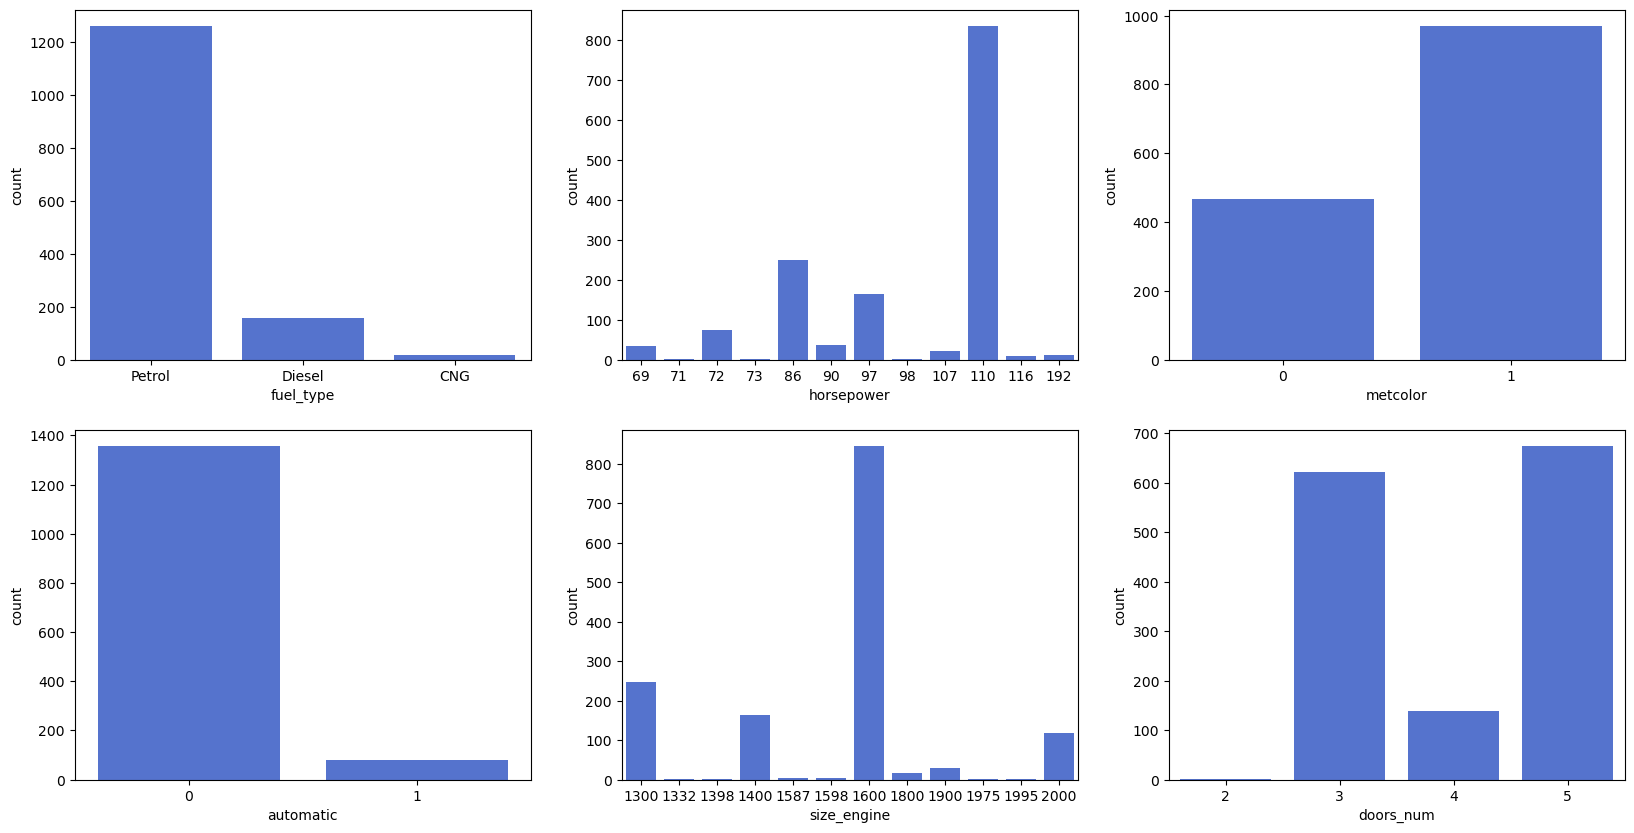

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for i, var in enumerate(categorical_vars):
    sns.countplot(x=var, data=df, ax=ax[i//3, i%3], color='royalblue')

plt.show()

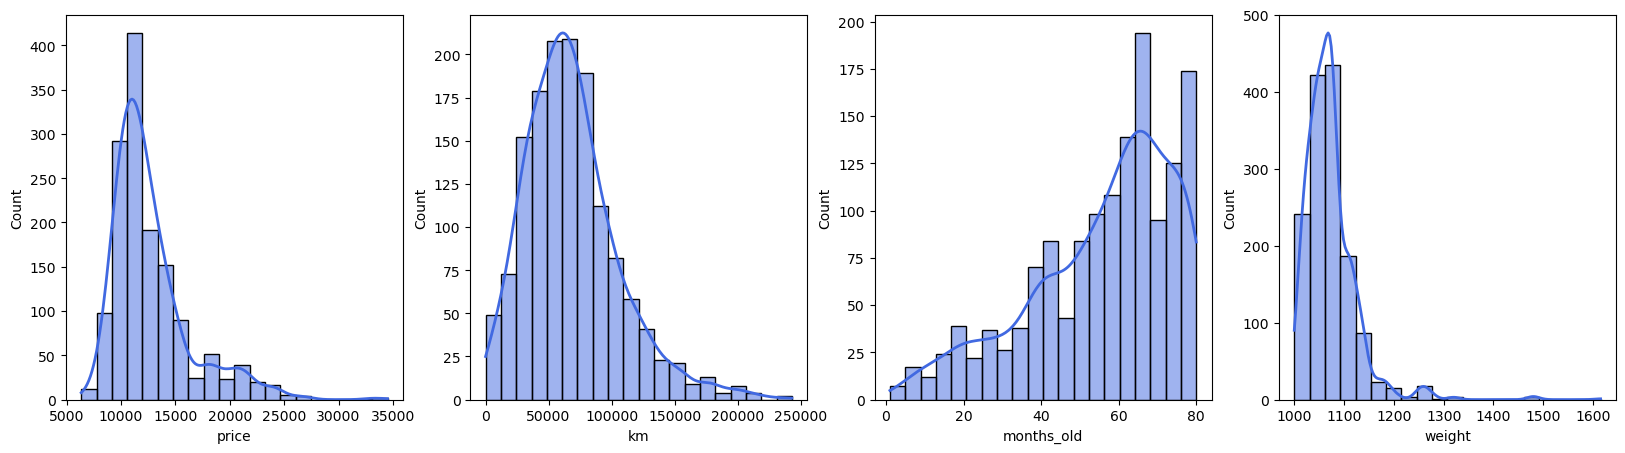

In [8]:
fig, ax = plt.subplots(1, len(continuos_vars), figsize=(20, 5))

for var, ax in zip(continuos_vars, ax.flatten()):
    sns.histplot(x=var, data=df, ax=ax, kde=True, color='royalblue', bins=20)
plt.show()

### Correlations

In [9]:
label_encoder = LabelEncoder()
df['fuel_type'] = label_encoder.fit_transform(df['fuel_type'].values)

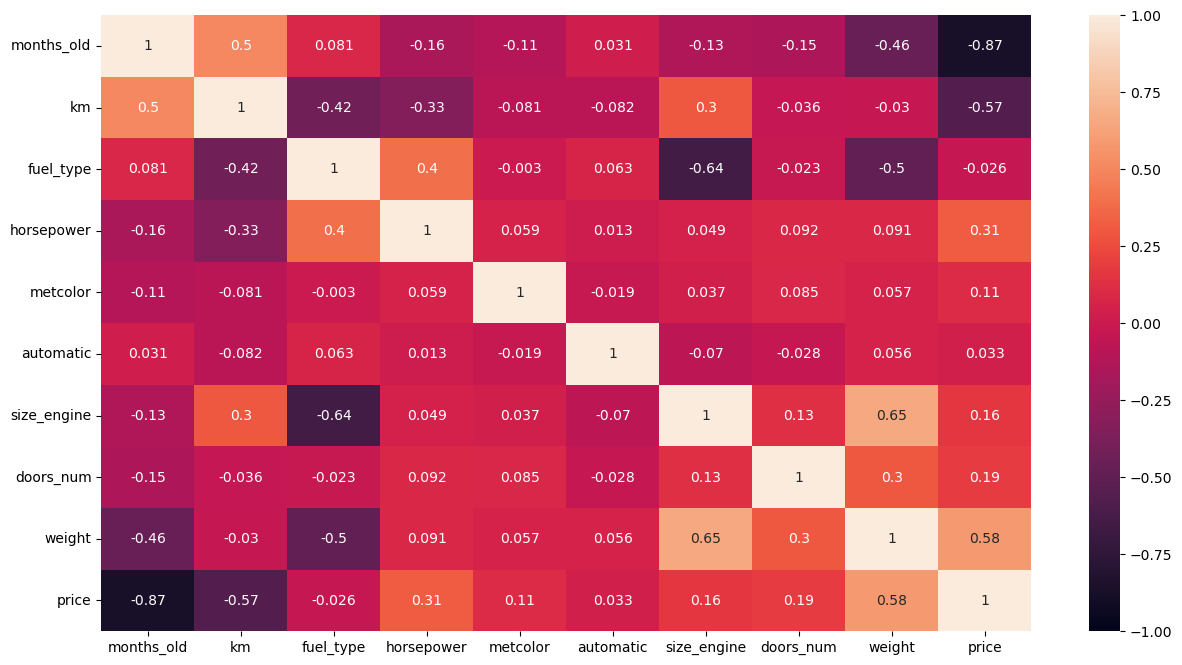

In [10]:
plt.figure(figsize=(15, 8))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

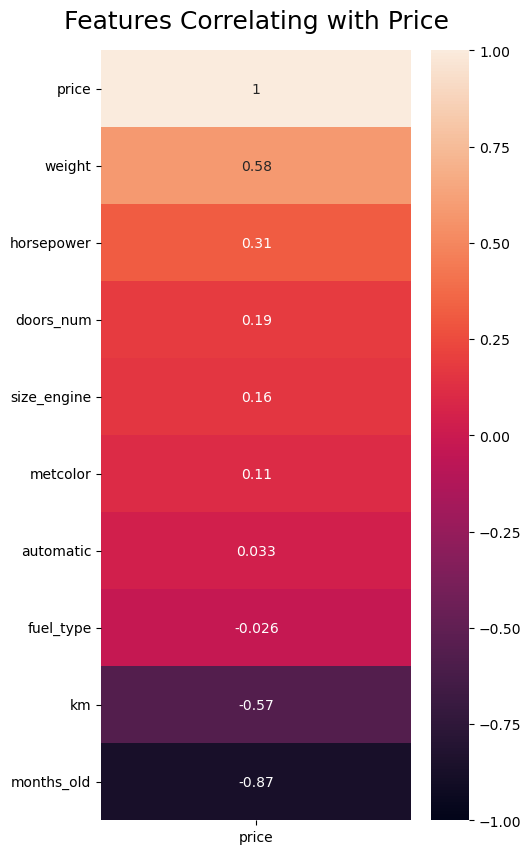

In [11]:
plt.figure(figsize=(5, 10))

heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':18}, pad=16);

# ANN: Classification

In [12]:
price_conditions = [
    (df['price'] < 11000),
    (df['price'] >= 11000) & (df['price'] < 13000),
    (df['price'] >= 13000)
]
choices = ['low-end', 'mid-range', 'high-end']

df['quality'] = np.select(price_conditions, choices, default='none')

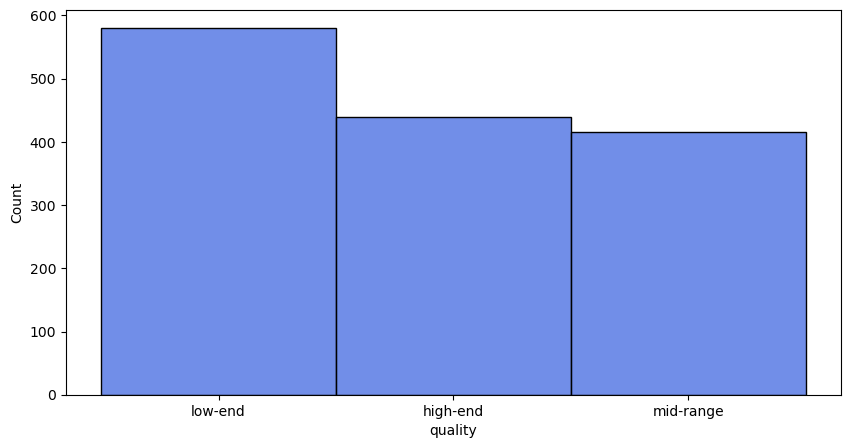

In [15]:
sns.histplot(df['quality'], color='royalblue')

plt.show()

In [16]:
df.head()

,months_old,km,fuel_type,horsepower,metcolor,automatic,size_engine,doors_num,weight,price,quality
0,73,97494,2,110,1,0,1600,5,1085,10950,low-end
1,48,89049,2,97,1,0,1400,5,1060,13500,high-end
2,40,161000,1,69,1,0,1900,3,1105,13950,high-end
3,37,38812,2,97,0,0,1400,3,1025,13450,high-end
4,55,33230,2,110,0,0,1600,3,1050,13500,high-end


In [17]:
features = df.iloc[:,:10].values
labels = df.iloc[:,10:11].values

In [20]:
# Standaritzation

sc = StandardScaler()
features_scaled = sc.fit_transform(features)

In [23]:
# Normalization

norm = MinMaxScaler()
features_norm = norm.fit_transform(features)

In [24]:
# One Hot Encoder Target

one_hot = OneHotEncoder()

labels = one_hot.fit_transform(labels).toarray()

In [25]:
# Split

train_x, test_x, train_y, test_y = train_test_split(features_scaled, labels, test_size=0.2)

In [26]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(1148, 10)
(288, 10)
(1148, 3)
(288, 3)


## Base Model

In [33]:
batch_size = 64
learning_rate = 0.1
epochs = 20

model = Sequential()
model.add(Dense(64, input_dim=train_x.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(labels.shape[1], activation='softmax'))

# Compile
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=learning_rate), 
              metrics=['accuracy'])

# Fit
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs = epochs,
                    batch_size = batch_size)



Epoch 1/20
18/18 [==============================] - 1s 18ms/step - loss: 1.0384 - accuracy: 0.4399 - val_loss: 0.7267 - val_accuracy: 0.6528
Epoch 2/20
18/18 [==============================] - 0s 4ms/step - loss: 0.6314 - accuracy: 0.7030 - val_loss: 0.4882 - val_accuracy: 0.8125
Epoch 3/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5259 - accuracy: 0.7666 - val_loss: 0.4453 - val_accuracy: 0.8368
Epoch 4/20
18/18 [==============================] - 0s 4ms/step - loss: 0.3790 - accuracy: 0.8693 - val_loss: 0.2803 - val_accuracy: 0.9132
Epoch 5/20
18/18 [==============================] - 0s 4ms/step - loss: 0.2739 - accuracy: 0.9094 - val_loss: 0.2048 - val_accuracy: 0.9410
Epoch 6/20
18/18 [==============================] - 0s 3ms/step - loss: 0.1955 - accuracy: 0.9434 - val_loss: 0.1602 - val_accuracy: 0.9549
Epoch 7/20
18/18 [==============================] - 0s 3ms/step - loss: 0.1722 - accuracy: 0.9503 - val_loss: 0.1716 - val_accuracy: 0.9306
Epoch 8/20
18/18 [=

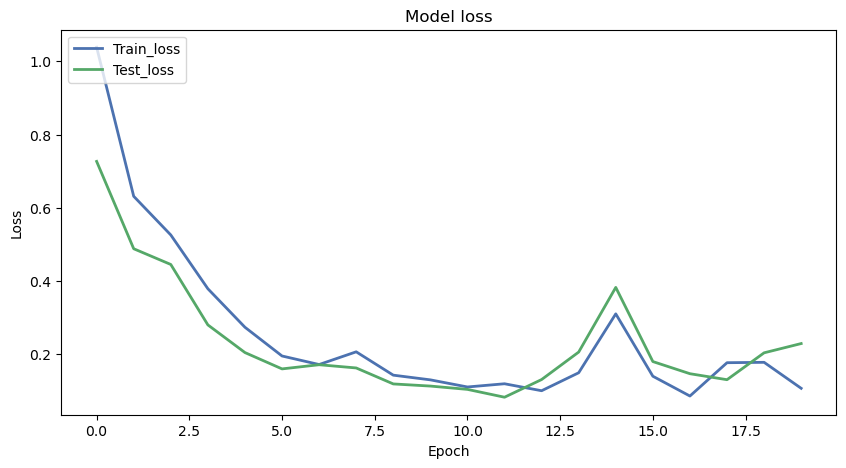

In [34]:
#LOSS PLOT  
def loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epoch') 
    plt.legend(['Train_loss', 'Test_loss'], loc='upper left') 
    plt.show()

loss_plot(history)

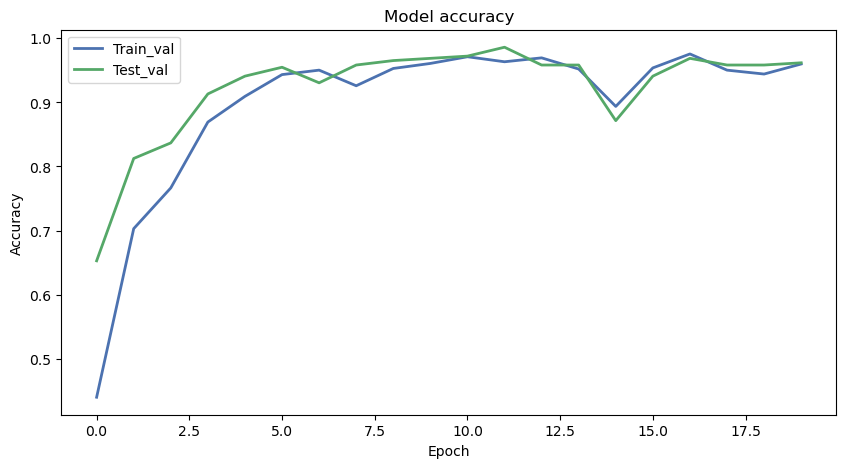

In [35]:
#Accuracy plot
def acc_plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train_val', 'Test_val'], loc='upper left')
    plt.show()
    
acc_plot(history)

In [36]:
# Split normalized

train_x_norm, test_x_norm, train_y_norm, test_y_norm = train_test_split(features_norm, labels, test_size=0.2)

In [32]:
batch_size = 64
learning_rate = 0.1
epochs = 20

model_norm = Sequential()
model_norm.add(Dense(64, input_dim=train_x_norm.shape[1], activation='relu'))
model_norm.add(Dense(32, activation='relu'))
model_norm.add(Dense(10, activation='relu'))
model_norm.add(Dense(8, activation='relu'))
model_norm.add(Dense(labels.shape[1], activation='softmax'))

# Compile
model_norm.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=learning_rate), 
              metrics=['accuracy'])

# Fit
history_2 = model_norm.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs = epochs,
                    batch_size = batch_size)


Epoch 1/20
18/18 [==============================] - 1s 19ms/step - loss: 0.9258 - accuracy: 0.5967 - val_loss: 0.7220 - val_accuracy: 0.7118
Epoch 2/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5575 - accuracy: 0.7735 - val_loss: 0.4126 - val_accuracy: 0.8542
Epoch 3/20
18/18 [==============================] - 0s 4ms/step - loss: 0.5653 - accuracy: 0.8389 - val_loss: 0.3014 - val_accuracy: 0.8924
Epoch 4/20
18/18 [==============================] - 0s 4ms/step - loss: 0.3184 - accuracy: 0.8841 - val_loss: 0.2800 - val_accuracy: 0.9062
Epoch 5/20
18/18 [==============================] - 0s 5ms/step - loss: 0.3748 - accuracy: 0.8859 - val_loss: 0.3127 - val_accuracy: 0.9132
Epoch 6/20
18/18 [==============================] - 0s 4ms/step - loss: 0.3318 - accuracy: 0.8998 - val_loss: 0.3223 - val_accuracy: 0.9062
Epoch 7/20
18/18 [==============================] - 0s 3ms/step - loss: 0.3078 - accuracy: 0.9103 - val_loss: 0.2136 - val_accuracy: 0.9410
Epoch 8/20
18/18 [=

In [37]:
BATCH_SIZE = 32
EPOCHS = 20

In [42]:
def modelLrOptimizer(optimizer, lrate):
    acc = []
    t = []
    for lr in lrate:
        model = Sequential()
        model.add(Dense(128, input_dim=train_x.shape[1], activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(labels.shape[1], activation='softmax'))
        
        model.compile(loss='categorical_crossentropy', optimizer=optimizer(learning_rate=lr), metrics=['accuracy'])
        start_time = timeit.default_timer()
        history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
        t.append(timeit.default_timer() - start_time)
        acc.append(model.evaluate(test_x, test_y, verbose=0)[1])
        
    return history, model, t, acc

In [43]:
lr = [0.001,0.01,0.05,0.1]
print("Training Adam models...")
histAdam, modAdam, tAdam, accAdam = modelLrOptimizer(Adam, lr)
print("Training SGD models...")
histSGD, modSGD, tSGD, accSGD = modelLrOptimizer(SGD, lr)
print("Training Adadelta models...")
histAdadelta, modAdadelta, tAdadelta, accAdadelta = modelLrOptimizer(Adadelta, lr)
print("Training Adagrad models...")
histAdagrad, modAdagrad, tAdagrad, accAdagrad = modelLrOptimizer(Adagrad, lr)

Training Adam models...
Training SGD models...
Training Adadelta models...
Training Adagrad models...


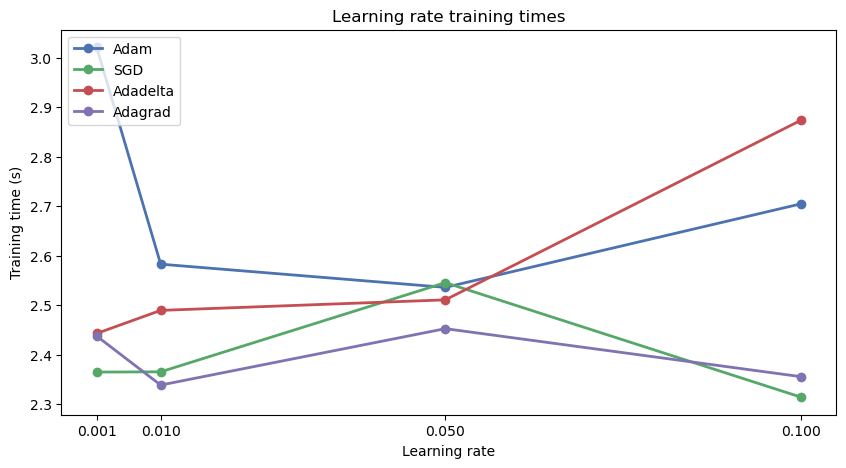

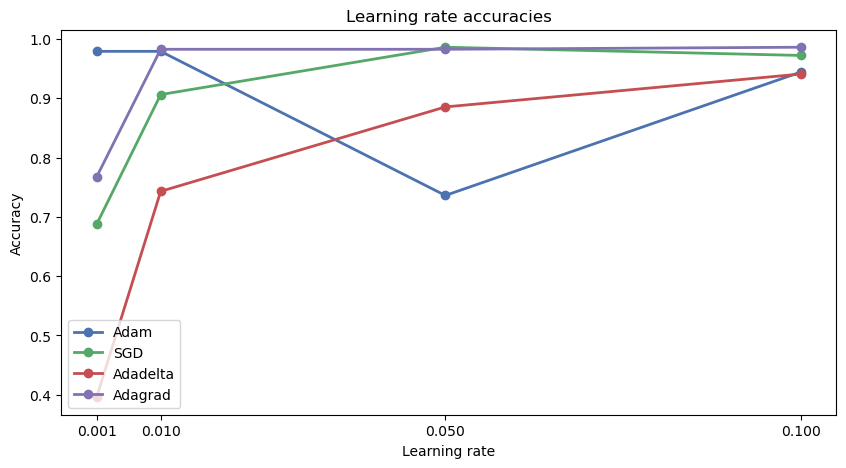

In [54]:
lr = [0.001, 0.01, 0.05, 0.1]
plt.plot(lr, tAdam, marker="o")
plt.plot(lr, tSGD, marker="o")
plt.plot(lr, tAdadelta, marker="o")
plt.plot(lr, tAdagrad, marker="o")
plt.title('Learning rate training times')
plt.ylabel('Training time (s)')
plt.xlabel('Learning rate')
plt.xticks(lr)
plt.legend(['Adam', 'SGD', 'Adadelta', 'Adagrad'], loc='upper left')
plt.show()

lr = [0.001, 0.01, 0.05, 0.1]
plt.plot(lr, accAdam, marker="o")
plt.plot(lr, accSGD, marker="o")
plt.plot(lr, accAdadelta, marker="o")
plt.plot(lr, accAdagrad, marker="o")
plt.title('Learning rate accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Learning rate')
plt.xticks(lr)
plt.legend(['Adam', 'SGD', 'Adadelta', 'Adagrad'], loc='lower left')
plt.show()

## Best Model

In [55]:
batch_size = 64
learning_rate = 0.01
epochs = 20

model = Sequential()
model.add(Dense(64, input_dim=train_x.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(labels.shape[1], activation='softmax'))

# Compile
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=learning_rate), 
              metrics=['accuracy'])

# Fit
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs = epochs,
                    batch_size = batch_size)

Epoch 1/20
18/18 [==============================] - 1s 25ms/step - loss: 0.6676 - accuracy: 0.6977 - val_loss: 0.3347 - val_accuracy: 0.8819
Epoch 2/20
18/18 [==============================] - 0s 6ms/step - loss: 0.3106 - accuracy: 0.8650 - val_loss: 0.2149 - val_accuracy: 0.9236
Epoch 3/20
18/18 [==============================] - 0s 4ms/step - loss: 0.1938 - accuracy: 0.9268 - val_loss: 0.1852 - val_accuracy: 0.9271
Epoch 4/20
18/18 [==============================] - 0s 4ms/step - loss: 0.1216 - accuracy: 0.9486 - val_loss: 0.0990 - val_accuracy: 0.9653
Epoch 5/20
18/18 [==============================] - 0s 5ms/step - loss: 0.0849 - accuracy: 0.9686 - val_loss: 0.1178 - val_accuracy: 0.9514
Epoch 6/20
18/18 [==============================] - 0s 4ms/step - loss: 0.0969 - accuracy: 0.9643 - val_loss: 0.1397 - val_accuracy: 0.9236
Epoch 7/20
18/18 [==============================] - 0s 4ms/step - loss: 0.0899 - accuracy: 0.9686 - val_loss: 0.1430 - val_accuracy: 0.9549
Epoch 8/20
18/18 [=

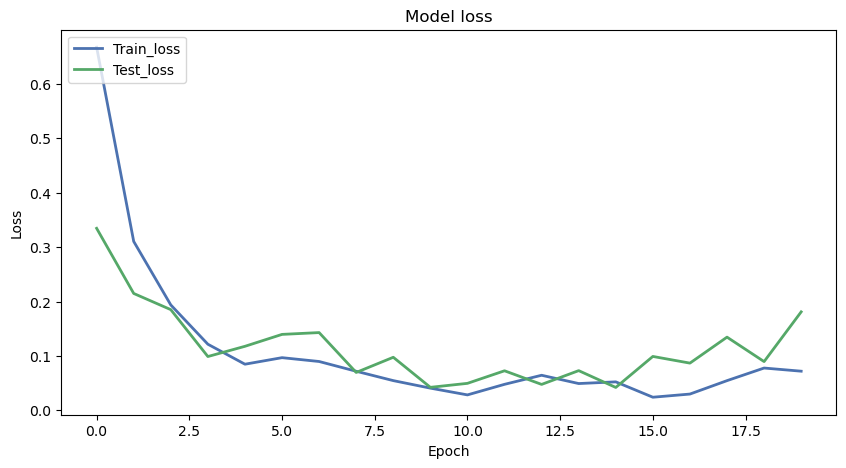

In [56]:
loss_plot(history)

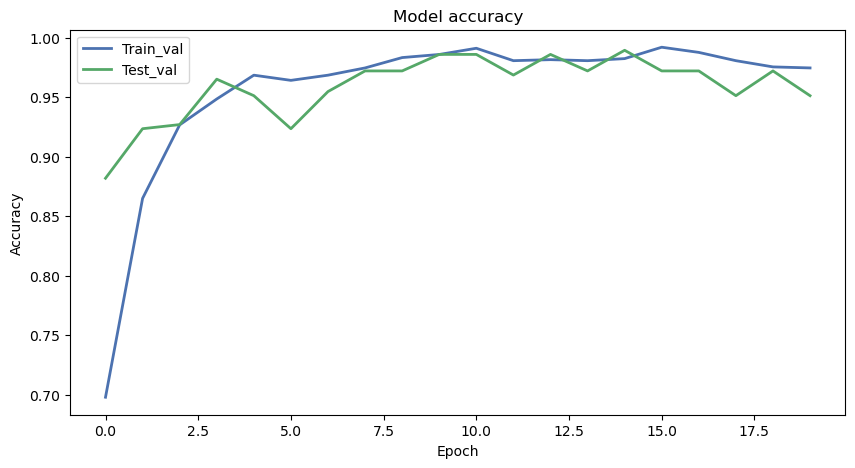

In [57]:
acc_plot(history)

In [58]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

9/9 [==============================] - 0s 1ms/step


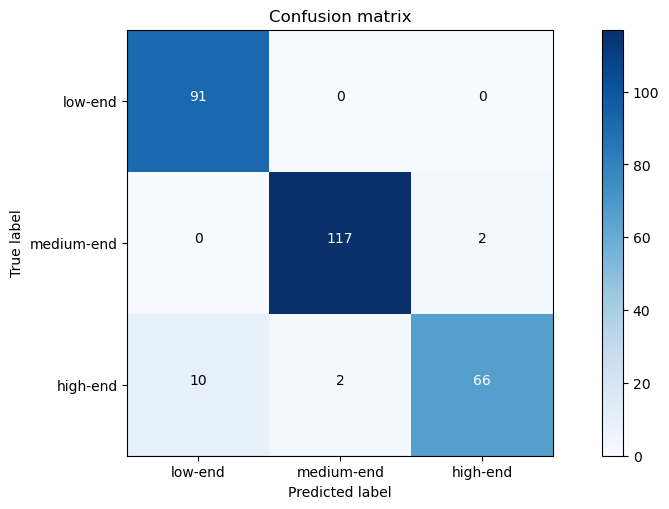

In [59]:
pred = model.predict(test_x)
cm = confusion_matrix(test_y.argmax(axis=1), pred.argmax(axis=1))
np.set_printoptions(precision=2)
class_names = ['low-end','medium-end', 'high-end']
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.show()

In [61]:
model.evaluate(test_x, test_y, verbose=0)[1]

0.9513888955116272

In [62]:
print(classification_report(test_y.argmax(axis=1), pred.argmax(axis=1), target_names=class_names))

              precision    recall  f1-score   support

     low-end       0.90      1.00      0.95        91
  medium-end       0.98      0.98      0.98       119
    high-end       0.97      0.85      0.90        78

    accuracy                           0.95       288
   macro avg       0.95      0.94      0.95       288
weighted avg       0.95      0.95      0.95       288

